# Imports

In [44]:
import torchvision.models as models
import torch
from torch import Tensor
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
import os
from tqdm import tqdm
import numpy as np
from vast.opensetAlgos.openmax import fit_high
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
import hdbscan as hdb
import matplotlib.pyplot as plt


# Helper Functions

In [2]:
def euclidean_pairwisedistance(x: Tensor, y: Tensor) -> Tensor:
    """
    Computes batched the p-norm distance between each pair of the two collections of row vectors.
    :param x: Tensor of size BxPxM
    :param y: Tensor of size BxRxM
    :returns: A Tensor of shape BxPxR
    """
    return torch.cdist(x, y, p=2, compute_mode="donot_use_mm_for_euclid_dist")


def cosine_pairwisedistance(x, y):
    x = nn.functional.normalize(x, dim=1)
    y = nn.functional.normalize(y, dim=1)
    similarity = torch.einsum("nc,ck->nk", [x, y.T])
    distances = 1 - similarity
    return distances

In [3]:
def transpose(x):
    """Used for correcting rotation of EMNIST Letters"""
    return x.transpose(2, 1)

In [4]:
def multiply_tensors_with_sign(sorted_activations, weights):
    mask = sorted_activations < 0
    weights[mask] = 1 + (
        1 - weights[mask]
    )  # Change negative values to 50.0 or any other desired value
    return sorted_activations * weights

# Openmax

## Training

In [5]:
def openmax_training(
    features_labels_all_classes_dict: dict,
    distance_multiplier: int = 2,
    tailsize: int = 100,
):
    # Tuple[dict[str, weibull], dict[str, Tensor]]:
    """
    :param pos_classes_to_process: List of class names to be processed by this function in the current process.
    :param features_all_classes: features of all classes
    """

    model_ = {}
    for label in features_labels_all_classes_dict.keys():
        model_per_label = {}
        features: Tensor = features_labels_all_classes_dict[label]
        mean_av_tensor = torch.mean(features, dim=0)

        model_per_label["mav"] = mean_av_tensor[None, :]

        distances: Tensor = cosine_pairwisedistance(
            features, mean_av_tensor[None, :]
        )
        model_per_label["weibull"] = fit_high(
            distances.T, distance_multiplier, tailsize, translateAmount=1
        )
        model_[label] = model_per_label

    return model_

## Inference

In [6]:
def openmax_inference(features_all_classes: dict, model_) -> dict:  # dict[str, Tensor],
    # features: Tensor = torch.cat(list(features_all_classes.values()))
    props_dict: dict = {}
    for class_label in features_all_classes:
        features = features_all_classes[class_label]
        probs = []
        for model_label in sorted(model_.keys()):
            # mav: Tensor = torch.stack(list(mean_av_dict.values()))
            mav: Tensor = model_[model_label]["mav"]
            distances: Tensor = cosine_pairwisedistance(features, mav)
            probs.append(
                model_[model_label]["weibull"].wscore(distances, isReversed=True)
            )  # TODO: Reversed? 1 - weibull.cdf
        probs = torch.cat(probs, dim=1)
        props_dict[class_label] = probs

    return props_dict

## Alpha

In [7]:
def openmax_alpha(
    evt_probs: Tensor, activations: Tensor, alpha: int, negative_fix=None, debug=False, ignore_unknown_class=False
):
    # Convert to Unknowness
    per_class_unknownness_prob = 1 - evt_probs

    # Line 1: Sort for highest activation value
    sorted_activations, indices = torch.sort(activations, descending=True, dim=1)
    if debug:
        print(activations.shape)
        print(sorted_activations.shape)
        print(indices.shape)

    # Create weights of ones in correct shape
    weights = torch.ones(activations.shape[0], activations.shape[1])
    if debug:
        print("LINE [1]: weights", weights)

    # Line 2-4
    # Creating a sequence of integers from 1 to alpha (inclusive) with a stepsize 1
    # Sequence is assigned to the first alpha columns of all rows in weights
    weights[:, :alpha] = torch.arange(1, alpha + 1, step=1)
    if debug:
        print("LINE [2-4]a: weights", weights)

    # Subtracts the current value in these position alpha and then divides the result by alpha (elementwise)
    weights[:, :alpha] = (alpha - weights[:, :alpha]) / alpha
    if debug:
        print("LINE [2-4]b: weights", weights)

    weights[:, :alpha] = 1 - weights[:, :alpha] * torch.gather(
        per_class_unknownness_prob, 1, indices[:, :alpha]
    )
    if debug:
        print("LINE [2-4]c: weights", weights)

    if negative_fix == "VALUE_SHIFT":
        assert not torch.any(
            torch.lt(weights, 0)
        ), "The tensor contains a negative value"
        # Get the minimum values for each row
        min_values = torch.min(sorted_activations, dim=1).values

        # Reshape the min_values tensor to match the shape of 'a' for broadcasting
        min_values_reshaped = min_values.view(-1, 1)
        min_values_reshaped_abs = torch.abs(min_values_reshaped)

        # Add the minimum values to the corresponding rows of the original tensor
        sorted_activations = torch.add(sorted_activations, min_values_reshaped_abs)
 
        if debug:
            print("LINE [2-4]d VALUE_SHIFT:", sorted_activations)

    # Line 5
    if negative_fix == "ABS_REV_ACTV":
        revisted_activations = multiply_tensors_with_sign(sorted_activations, weights)
        if debug:
            print("LINE [5] ABS_REV_ACTV:", revisted_activations)
    else:
        revisted_activations = sorted_activations * weights
        if debug:
            print("LINE [5]: ", revisted_activations)

    # Line 6
    unknowness_class_prob = torch.sum(sorted_activations * (1 - weights), dim=1)
    revisted_activations = torch.scatter(
        torch.ones(revisted_activations.shape), 1, indices, revisted_activations
    )
    if debug:
        print("LINE [6]a: unknowness class p", unknowness_class_prob)
        print("LINE [6]b: revisted_act", revisted_activations)

    probability_vector = torch.cat(
        [unknowness_class_prob[:, None], revisted_activations], dim=1
    )
    if debug:
        print("LINE [6]c: prob vec", probability_vector)

    # Line 7
    probability_vector = torch.nn.functional.softmax(probability_vector, dim=1)
    if debug:
        print("LINE [7]: softmax prob vec", probability_vector)
        
    if ignore_unknown_class:
        probs_kkc = probability_vector[:, 1:].clone().detach()
        assert probs_kkc.shape == activations.shape
        return probs_kkc

    # Line 8
    prediction_score, predicted_class = torch.max(probability_vector, dim=1)
    if debug:
        print("LINE [8]a: prediction_score", prediction_score)
    if debug:
        print("LINE [8]b: predicted_class", predicted_class)

    # Line 9
    prediction_score[predicted_class == 0] = -1.0
    predicted_class = predicted_class - 1

    return predicted_class, prediction_score

# Data
- Source: [EOS-Training](https://gitlab.uzh.ch/manuel.guenther/eos-example/-/blob/EMNIST-digits/EOS_Training.py?ref_type=heads#L44)

## Dataset

In [9]:
class Cluster_Dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, data, targets, dataset_root,
        which_set="train",):
        self.images = torchvision.datasets.EMNIST(
            root=dataset_root,
            train=which_set == "train",
            download=True,
            split="mnist",
            transform=transforms.Compose([transforms.ToTensor(), transpose]),
        )
        print(self.images.data.shape, torch.tensor(data).shape)
        self.images.data = torch.tensor(data)
        self.images.targets = targets
        
    def __getitem__(self, idx):
        return self.images[idx]
    
    def __len__(self):
        return len(self.images)

In [45]:
class Dataset(torch.utils.data.dataset.Dataset):
    """A split dataset for our experiments. It uses MNIST as known samples and EMNIST letters as unknowns.
    Particularly, the 11 letters will be used as negatives (for training and validation), and the 11 letters will serve as unknowns (for testing only) -- we removed letters `g`, `l`, `i` and `o` due to large overlap to the digits.
    The MNIST test set is used both in the validation and test split of this dataset.

    For the test set, you should consider to leave the parameters `include_unknown` and `has_garbage_class` at their respective defaults -- this might make things easier.

    Parameters:

    dataset_root: Where to find/download the data to.

    which_set: Which split of the dataset to use; can be 'train' , 'test' or 'validation' (anything besides 'train' and 'test' will be the validation set)

    include_unknown: Include unknown samples at all (might not be required in some cases, such as training with plain softmax)

    has_garbage_class: Set this to True when training softmax with background class. This way, unknown samples will get class label 10. If False (the default), unknown samples will get label -1.
    """

    def __init__(
        self,
        dataset_root,
        which_set="train",
        include_unknown=True,
        has_garbage_class=False,
        use_clusters=False,
        num_clusters_per_class=1,
    ):
        self.mnist = torchvision.datasets.EMNIST(
            root=dataset_root,
            train=which_set == "train",
            download=True,
            split="mnist",
            transform=transforms.Compose([transforms.ToTensor(), transpose]),
        )
        self.letters = torchvision.datasets.EMNIST(
            root=dataset_root,
            train=which_set == "train",
            download=True,
            split="letters",
            transform=transforms.Compose([transforms.ToTensor(), transpose]),
        )
        self.which_set = which_set
        targets = (
            list()
            if not include_unknown
            else [1, 2, 3, 4, 5, 6, 8, 10, 11, 13, 14]
            if which_set != "test"
            else [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
        )
        self.letter_indexes = [
            i for i, t in enumerate(self.letters.targets) if t in targets
        ]
        self.has_garbage_class = has_garbage_class
        self.use_clusters = use_clusters
        
        if use_clusters:
            self.mnist = clustering(self.mnist, num_clusters_per_class)
        
        

    def __getitem__(self, index):
        if index < len(self.mnist):
            return self.mnist[index]
        else:
            return (
                self.letters[self.letter_indexes[index - len(self.mnist)]][0],
                10 if self.has_garbage_class else -1,
            )

    def __len__(self):
        return len(self.mnist) + len(self.letter_indexes)

## Initialization

Size training dataset 60000 1875
Size validation dataset 10000 313
Size test dataset 18800
Numbers: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Letters: ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[1, 8, 6, 7, 8, 0, 8, 1]
[1, 8, 6, 7, 8, 0, 8, 1]
Number Label: 0


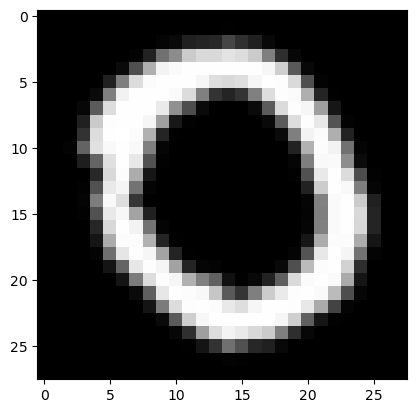

In [53]:
BATCH_SIZE = 32

training_data = Dataset(
    dataset_root="../downloads/",
    which_set="train",
    include_unknown=False,
    has_garbage_class=False,
)
validation_data = Dataset(
    dataset_root="../downloads/",
    which_set="val",
    include_unknown=False,
    has_garbage_class=False,
)
test_data = Dataset(
    dataset_root="../downloads/",
    which_set="test",
    include_unknown=True,
    has_garbage_class=False,
)

train_data_loader = torch.utils.data.DataLoader(
    training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=5, pin_memory=True
)
val_data_loader = torch.utils.data.DataLoader(
    validation_data, batch_size=BATCH_SIZE, pin_memory=True
)

print("Size training dataset", len(training_data), len(train_data_loader))
print("Size validation dataset", len(validation_data), len(val_data_loader))
print("Size test dataset", len(test_data))
print("Numbers:", training_data.mnist.classes)
print(
    "Letters:",
    test_data.letters.classes,
)

v = [ x for x in validation_data][:8]

t = [ x for x in test_data][:8]

print(v_targets[:8])
print(t_targets[:8])



c = v + t
idx = 5
imagev, label_v = v[idx]
imaget, label_t = t[idx]
label -= 1
print(f"Number Label: {label_v}")
plt.imshow(imagev[0], cmap="gray")


Number Label: 0


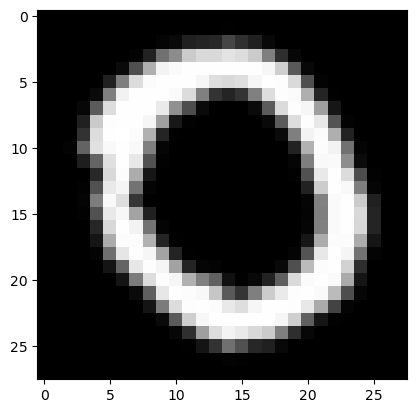

In [54]:
print(f"Number Label: {label_t}")
plt.imshow(imaget[0], cmap="gray")

### Vis Numbers

Number Label: 6


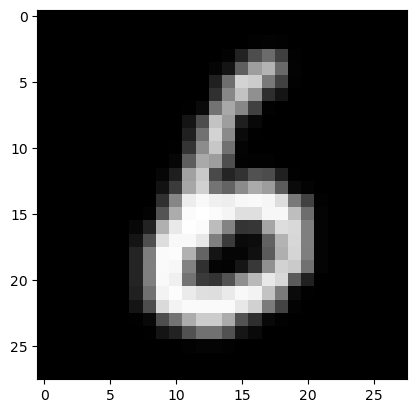

In [12]:
idx = np.random.randint(0, len(validation_data.mnist))
image, label = validation_data[idx]
label -= 1
plt.imshow(image[0], cmap="gray")
print(f"Number Label: {validation_data[idx][1]}")

### Vis Letters

Letter Label: z


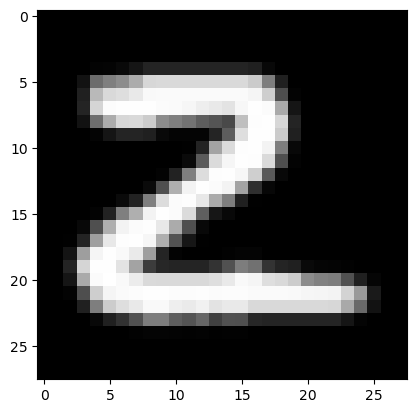

In [13]:
idx = np.random.randint(0, len(validation_data.letters))
image, label = validation_data.letters[idx]
label -= 1
plt.imshow(image[0], cmap="gray")
print(f"Letter Label: {validation_data.letters.classes[validation_data.letters[idx][1]]}")

# Clustering

## Clustering Algorithms

In [14]:
def dbscan(eps_: int, min_samples_: int, clustering_data):
    clusterer_dbscan = DBSCAN(eps=eps_, min_samples=min_samples_, metric='euclidean').fit(clustering_data)

    n_clusters_ = len(set(clusterer_dbscan.labels_)) - (
        1 if -1 in clusterer_dbscan.labels_ else 0
    )
    n_noise_ = list(clusterer_dbscan.labels_).count(-1)

    return clusterer_dbscan, n_clusters_, n_noise_

def plot_dbscan(clusterer_dbscan, data_embedded, n_clusters_, n_noise_):
    nr_colors = len(set(clusterer_dbscan.labels_))
    dbscan_labels = clusterer_dbscan.labels_
    color_palette = sns.color_palette("Paired", nr_colors)
    cluster_colors = [
        color_palette[x] if x >= 0 else (0.5, 0.5, 0.5)
        for x in clusterer_dbscan.labels_
    ]
    plt.scatter(*data_embedded.T, s=20, linewidth=0, c=cluster_colors, alpha=0.25)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)

### HDBSCAN

In [15]:
def hdbscan(min_cluster_size_, min_samples_, clustering_data):
    clusterer_hdbscan = hdb.HDBSCAN(min_cluster_size=min_cluster_size_).fit(
        clustering_data
    )

    n_clusters_ = len(set(clusterer_hdbscan.labels_)) - (
        1 if -1 in clusterer_hdbscan.labels_ else 0
    )
    n_noise_ = list(clusterer_hdbscan.labels_).count(-1)

    return clusterer_hdbscan, n_clusters_, n_noise_

def plot_hdbscan(clusterer_hdbscan, data_embedded, n_clusters_, n_noise_):
    nr_colors = len(set(clusterer_hdbscan.labels_))
    color_palette = sns.color_palette("Paired", nr_colors)
    cluster_colors = [
        color_palette[x] if x >= 0 else (0.5, 0.5, 0.5)
        for x in clusterer_hdbscan.labels_
    ]
    cluster_member_colors = [
        sns.desaturate(x, p)
        for x, p in zip(cluster_colors, clusterer_hdbscan.probabilities_)
    ]
    plt.scatter(
        *data_embedded.T, s=20, linewidth=0, c=cluster_member_colors, alpha=0.25
    )

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)


### Agglomerative  Clustering

In [16]:
def agglo_clustering(n_clusters_, linkage_, metric_, clustering_data):
    clusterer_agglo = AgglomerativeClustering(
        n_clusters=n_clusters_, linkage=linkage_, metric=metric_
    )
    clusterer_agglo.fit_predict(clustering_data)
    return clusterer_agglo


def plot_agglo(clusterer_agglo, data_embedded):
    nr_colors = len(set(clusterer_agglo.labels_))
    color_palette = sns.color_palette("Paired", nr_colors)
    cluster_colors = [
        color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer_agglo.labels_
    ]
    plt.scatter(*data_embedded.T, s=20, linewidth=0, c=cluster_colors, alpha=0.25)
    n_clusters_ = len(set(clusterer_agglo.labels_)) - (
        1 if -1 in clusterer_agglo.labels_ else 0
    )
    print("Estimated number of clusters: %d" % n_clusters_)

## Input Clustering

In [17]:
cluster_data = training_data.mnist.data.numpy()
cluster_targets = training_data.mnist.targets.numpy()
print(cluster_data.shape)
# cluster_data_transposed = cluster_data.transpose(0, 2, 1)
cluster_data_transposed = cluster_data
cluster_data_reshaped = cluster_data_transposed.reshape(cluster_data_transposed.shape[0], -1)
print(cluster_data_reshaped.shape)
cluster_data_dict = {}
for i in range(len(cluster_data)):
    label = cluster_targets[i]
    if label in cluster_data_dict.keys():
        cluster_data_dict[label] = np.vstack([cluster_data_dict[label], cluster_data_reshaped[i]])
    else:
        cluster_data_dict[label] = cluster_data_reshaped[i]
print(cluster_data_dict[9].shape)

(60000, 28, 28)
(60000, 784)
(6000, 784)


In [18]:
from collections import Counter

n_clusters = 5
linkage = "ward"
metric = "euclidean"
clusterer_dict = {}
for key in cluster_data_dict.keys():
    clusterer = agglo_clustering(n_clusters, linkage, metric, cluster_data_dict[key])
    clusterer_dict[key] = clusterer

In [19]:
targets_ = np.array([], dtype=np.uint8)
for key in sorted(clusterer_dict.keys()):
    cluster_labels = clusterer_dict[key].labels_
    cluster_labels_new = cluster_labels + key * n_clusters
    # cluster_labels_new = [key] * len(cluster_labels)
    print(key, set(cluster_labels_new), cluster_labels, cluster_labels_new)
    targets_ = np.append(targets_, cluster_labels_new)
targets_.shape

0 {0, 1, 2, 3, 4} [0 1 4 ... 4 3 0] [0 1 4 ... 4 3 0]
1 {5, 6, 7, 8, 9} [2 3 1 ... 4 1 0] [7 8 6 ... 9 6 5]
2 {10, 11, 12, 13, 14} [3 0 0 ... 2 2 3] [13 10 10 ... 12 12 13]
3 {15, 16, 17, 18, 19} [1 1 0 ... 2 4 4] [16 16 15 ... 17 19 19]
4 {20, 21, 22, 23, 24} [1 2 0 ... 0 3 2] [21 22 20 ... 20 23 22]
5 {25, 26, 27, 28, 29} [0 2 1 ... 0 1 3] [25 27 26 ... 25 26 28]
6 {32, 33, 34, 30, 31} [2 4 4 ... 1 0 3] [32 34 34 ... 31 30 33]
7 {35, 36, 37, 38, 39} [2 2 2 ... 0 2 0] [37 37 37 ... 35 37 35]
8 {40, 41, 42, 43, 44} [2 2 0 ... 0 4 0] [42 42 40 ... 40 44 40]
9 {45, 46, 47, 48, 49} [0 2 3 ... 1 0 0] [45 47 48 ... 46 45 45]


(60000,)

In [20]:
reshaped_matrices = []
for key in sorted(clusterer_dict.keys()):
    img_reshaped = cluster_data_dict[key].reshape(6000, 28, 28)
    # img_reshaped = cluster_data_dict[key].reshape(6000, 28, 28)
    reshaped_matrices.append(img_reshaped)
img_ = np.array(np.concatenate(reshaped_matrices))
img_.shape


(60000, 28, 28)

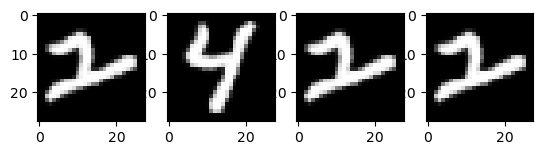

In [21]:
fig, axs = plt.subplots(1, 4)
axs[0].imshow(np.reshape(cluster_data_reshaped[0], (28, 28)), cmap="gray")
axs[1].imshow(cluster_data[0].T, cmap="gray")
axs[2].imshow(np.reshape(cluster_data_dict[4][0], (28, 28)), cmap="gray")
axs[3].imshow(img_[24_000], cmap="gray")

plt.show()

# CNN
- Source: [Vast](https://github.com/Vastlab/vast/blob/63-network-architectures-include-bias-neuron-in-the-last-layer/vast/architectures/architectures.py#L77)

## Model

In [22]:
class LeNet(nn.Module):
    def __init__(
        self,
        use_classification_layer=True,
        use_BG=False,
        num_classes=10,
        final_layer_bias=True,
    ):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=20, kernel_size=(5, 5), stride=1, padding=2
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=self.conv1.out_channels,
            out_channels=50,
            kernel_size=(5, 5),
            stride=1,
            padding=2,
        )
        self.fc1 = nn.Linear(
            in_features=self.conv2.out_channels * 7 * 7, out_features=500, bias=True
        )
        if use_classification_layer:
            if use_BG:
                self.fc2 = nn.Linear(
                    in_features=500, out_features=num_classes + 1, bias=final_layer_bias
                )
            else:
                self.fc2 = nn.Linear(
                    in_features=500, out_features=num_classes, bias=final_layer_bias
                )
        self.relu_act = nn.ReLU()
        self.use_classification_layer = use_classification_layer
        print(
            f"{' Model Architecture '.center(90, '#')}\n{self}\n{' Model Architecture End '.center(90, '#')}"
        )

    def forward(self, x):
        act_conv1 = self.pool(self.relu_act(self.conv1(x)))
        act_conv2 = self.pool(self.relu_act(self.conv2(act_conv1)))
        act_conv2_reshaped = act_conv2.view(
            -1, self.conv2.out_channels * 7 * 7
        )  #  view method is used to reshape a tensor without changing its data.
        features = self.fc1(act_conv2_reshaped)
        if self.use_classification_layer:
            logits = self.fc2(features)
            predictions = nn.Softmax(dim=1)(logits)
            return predictions, logits, features
        return features

In [23]:
model = LeNet(
    use_classification_layer=True, use_BG=False, num_classes=10, final_layer_bias=True
)

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

################################### Model Architecture ###################################
LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=2450, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (relu_act): ReLU()
)
################################# Model Architecture End #################################


## Training

### Model with Classifier

In [24]:
path_model = "openmax_cnn_eminst0.pth"
# path_model = "openmax_model.pth"
if os.path.isfile(path_model):
    model.load_state_dict(torch.load(path_model))
    print(f"Loaded: {path_model}")

num_epochs = 1
features_dict = {}

randy = np.random.randint(0, len(training_data)/BATCH_SIZE)

model.train()
for epoch in range(num_epochs):
    with tqdm(train_data_loader, unit="batch") as tepoch:
        correct_predictions = 0
        total_loss = 0.0
        
        counter=0
        for batch_inputs, batch_labels in tepoch:
            tepoch.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

            optimizer.zero_grad()
            if counter == randy:
                batch_inputs_test0 = batch_inputs
                batch_labels_test0 = batch_labels
            counter += 1

            # Forward pass
            training_predictions, _, training_features = model(batch_inputs)

            if epoch == num_epochs - 1:
                _, training_pred = torch.max(training_predictions, 1)
                for pred, label, features in zip(
                    training_pred, batch_labels, training_features
                ):
                    if pred == label:
                        if label.item() in features_dict:
                            features_dict[label.item()] = torch.cat(
                                (features_dict[label.item()], features[None, :]), 0
                            )
                        else:
                            features_dict[label.item()] = features[None, :]

            loss = loss_fn(training_predictions, batch_labels)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(training_predictions, 1)
            correct_predictions += (predicted == batch_labels).sum().item()

            curr_acc = correct_predictions / len(training_data)
            tepoch.set_postfix(loss=loss.item(), acc=curr_acc)

        accuracy = correct_predictions / len(training_data)
        avg_loss = total_loss / len(train_data_loader)
        print(f"Average loss: {avg_loss:.3f} - Accuracy: {accuracy:.3f}")

# Save the trained model
torch.save(model.state_dict(), path_model)
print(f"Saved model: {path_model}")

Loaded: openmax_cnn_eminst0.pth


Epoch [1/1]: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:53<00:00, 34.99batch/s, acc=0.964, loss=1.46]

Average loss: 1.500 - Accuracy: 0.964
Saved model: openmax_cnn_eminst0.pth


- Adjust CCE to first log only target cluster(maximize), second log (minimize) remove cluster that are from the same nummer
- eval -> new formula see screenshot
- OSCR -> unknown not necessary, ander klassen runter trenieren darum trotzdem vonnöten
- logits openmax cluster -> score only for correct class

torch.Size([1, 28, 28])
tensor([2, 0, 3, 5, 0, 9, 6, 9, 1, 6, 0, 6, 0, 1, 5, 4, 5, 7, 0, 7, 0, 2, 1, 4,
        4, 9, 2, 5, 8, 4, 1, 6])


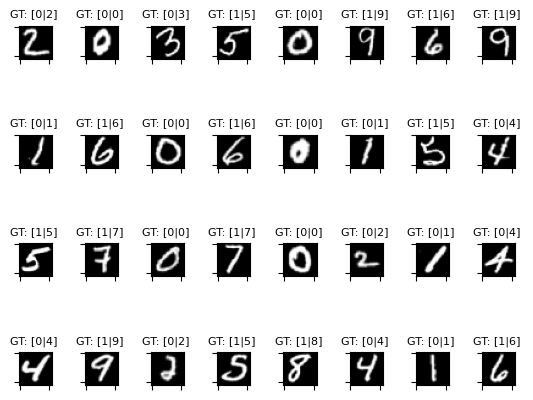

In [25]:
print(batch_inputs_test0[31].shape)
print((batch_labels_test0))
cols = 8
rows = len(batch_inputs_test0) // cols if len(batch_inputs_test0) % cols == 0 else len(batch_inputs_test0) // cols + 1
fig, axs = plt.subplots(rows, cols)
fig.subplots_adjust(hspace = 1.5, wspace=1)


counter = 0 
for row in range(rows):
    for col in range(cols):
        axs[row][col].imshow(batch_inputs_test0[counter][0], cmap="gray")
        axs[row][col].title.set_text(f'GT: [{batch_labels_test0[counter]//5}|{batch_labels_test0[counter]}] ')
        axs[row][col].set_xticklabels([])
        axs[row][col].set_yticklabels([])
        axs[row][col].title.set_fontsize(8)
        counter += 1
plt.show()

### Model with Clustering

In [26]:
cluster_training_dataset = Cluster_Dataset(img_, targets_, "./downloads/")
cluster_train_data_loader = torch.utils.data.DataLoader(
    cluster_training_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=5, pin_memory=True
)

torch.Size([60000, 28, 28]) torch.Size([60000, 28, 28])


In [27]:
cluster_model = LeNet(
    use_classification_layer=True, use_BG=False, num_classes=50, final_layer_bias=True
)

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cluster_model.parameters(), lr=learning_rate, momentum=0.98)

################################### Model Architecture ###################################
LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=2450, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=50, bias=True)
  (relu_act): ReLU()
)
################################# Model Architecture End #################################


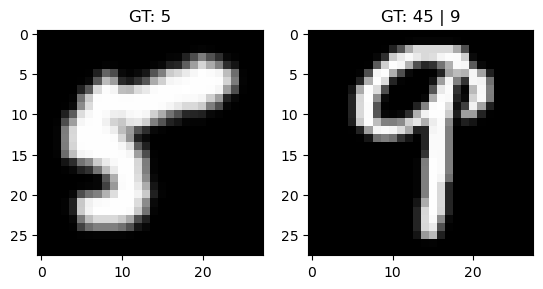

In [28]:
# training_data.mnist.targets = torch.zeros_like(training_data.mnist.targets)
# print(training_data[0][0].dtype, cluster_training_dataset[0][0].dtype)
# print(training_data[0][0].shape, cluster_training_dataset[0][0].shape)
fig, axs = plt.subplots(1, 2)
rd = np.random.randint(0,60000)
axs[0].imshow(training_data[rd][0][0], cmap="gray")
axs[0].title.set_text(f'GT: {training_data[rd][1]}')
axs[1].imshow(cluster_training_dataset[rd][0][0], cmap="gray")
axs[1].title.set_text(f'GT: {cluster_training_dataset[rd][1]} | {cluster_training_dataset[rd][1]//5}')
plt.show()

### Openmax Training

In [40]:
tail_sizes = [10, 100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
tail_sizes = [10, 100, 250, 500, 750, 1000]
# tail_sizes = [750, 1000]
# tail_sizes = np.arange(1500, 2500, 150)
print(tail_sizes)
distance_multpls = [1.50, 1.7, 2.0, 2.3, 2.5, 2.7, 3., 3.5, 4.]
distance_multpls = [1.50, 1.7, 2.0, 2.3]

# distance_multpls = [2.0, 2.5]
# distance_multpls = np.arange(2.0, 3.5, 0.25)
print(distance_multpls)

models_dict = {}

for tail in tail_sizes:
    for dist_mult in distance_multpls:
        model_ = openmax_training(features_dict, dist_mult, tail)
        key = f"{tail}-{dist_mult}"
        models_dict[key] = model_

[10, 100, 250, 500, 750, 1000]
[1.5, 1.7, 2.0, 2.3]


## Validation

In [30]:
if os.path.isfile(path_model):
    model.load_state_dict(torch.load(path_model))
    print(f"Loaded: {path_model}")

val_logits_dict = {}
val_features_dict = {}

with torch.no_grad():
    model.eval()
    with tqdm(val_data_loader, unit="batch") as tepoch:
        correct_predictions = 0
        total_loss = 0.0

        for batch_inputs, batch_labels in tepoch:
            tepoch.set_description(f"Validation")

            val_predictions, val_logits, val_features = model(batch_inputs)

            _, val_predicted = torch.max(val_predictions, 1)
            for pred, label, logits, features in zip(
                val_predicted, batch_labels, val_logits, val_features
            ):
                if label.item() in val_features_dict:
                    val_features_dict[label.item()] = torch.cat(
                        (val_features_dict[label.item()], features[None, :]), 0
                    )
                    val_logits_dict[label.item()] = torch.cat(
                        (val_logits_dict[label.item()], logits[None, :]), 0
                    )
                else:
                    val_features_dict[label.item()] = features[None, :]
                    val_logits_dict[label.item()] = logits[None, :]

            correct_predictions += (val_predicted == batch_labels).sum().item()
            
           #  loss = loss_fn(val_predictions, batch_labels)

            total_loss += loss.item()

            batch_acc = correct_predictions / len(validation_data)
            tepoch.set_postfix(loss=loss.item(), acc=batch_acc)

        accuracy = correct_predictions / len(validation_data)
        avg_loss = total_loss / len(val_data_loader)
        print(f"Average loss: {avg_loss:.3f} - Accuracy: {accuracy:.3f}")

Loaded: openmax_cnn_eminst0.pth


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 588/588 [00:10<00:00, 54.56batch/s, acc=0.51, loss=1.46]

Average loss: 1.461 - Accuracy: 0.510


## OpenMax

### Inference

In [41]:
models_props_dict = {}
for key in models_dict.keys():
    props_dict: dict = openmax_inference(val_features_dict, models_dict[key])
    models_props_dict[key] = props_dict

### Alpha

In [56]:
openmax_models_predictions = {}

for model_idx in models_dict.keys():
    openmax_prob_dict = {}
    for idx, key in enumerate(models_props_dict[model_idx].keys()):
        assert key == list(val_logits_dict.keys())[idx]
        assert (
            models_props_dict[model_idx][key].shape[1] == val_logits_dict[key].shape[1]
        )
        
        openmax_prob_dict[key]= openmax_alpha(
            models_props_dict[model_idx][key],
            val_logits_dict[key],
            alpha=9,
            negative_fix="VALUE_SHIFT",
            # negative_fix="ABS_REV_ACTV",
            debug=False,
            ignore_unknown_class=True
        )
    openmax_models_predictions[model_idx] = openmax_prob_dict

# Metrics

In [57]:
def calculate_oscr(gt, scores, unk_label=-1):
    """ Calculates the OSCR values, iterating over the score of the target class of every sample,
    produces a pair (ccr, fpr) for every score.
    Args:
        gt (np.array): Integer array of target class labels.
        scores (np.array): Float array of dim [N_samples, N_classes]
        unk_label (int): Label to calculate the fpr, either negatives or unknowns. Defaults to -1 (negatives)
    Returns: Two lists first one for ccr, second for fpr.
    """
    # Change the unk_label to calculate for kn_unknown or unk_unknown
    gt = gt.astype(int)
    kn = gt >= 0
    unk = gt == unk_label

    # Get total number of samples of each type
    total_kn = np.sum(kn)
    total_unk = np.sum(unk)

    ccr, fpr = [], []
    # get predicted class for known samples
    pred_class = np.argmax(scores, axis=1)[kn]
    correctly_predicted = pred_class == gt[kn]
    target_score = scores[kn][range(kn.sum()), gt[kn]]

    # get maximum scores for unknown samples
    max_score = np.max(scores, axis=1)[unk]

    # Any max score can be a threshold
    thresholds = np.unique(max_score)

    #print(target_score) #HB
    for tau in thresholds:
        # compute CCR value
        val = (correctly_predicted & (target_score >= tau)).sum() / total_kn
        ccr.append(val)

        val = (max_score >= tau).sum() / total_unk
        fpr.append(val)

    ccr = np.array(ccr)
    fpr = np.array(fpr)
    return ccr, fpr

In [58]:
def preprocess_oscr(class_scores_dict:dict):
    all_probs_per_model = []
    gt = []
    for key in class_scores_dict.keys():
        all_probs_per_model.append(class_scores_dict[key])
        gt += [key] * len(class_scores_dict[key])
    return np.array(gt), torch.cat(all_probs_per_model).numpy()
    
all_probs_all_models = {}
for model_key in openmax_models_predictions.keys():
    all_probs_all_models[model_key] = preprocess_oscr(openmax_models_predictions[model_key])

In [59]:
ccr_fpr_dict = {}
for model_key in all_probs_all_models.keys():
    ccr_fpr_dict[model_key] = calculate_oscr(all_probs_all_models[model_key][0], all_probs_all_models[model_key][1])

## OSCR

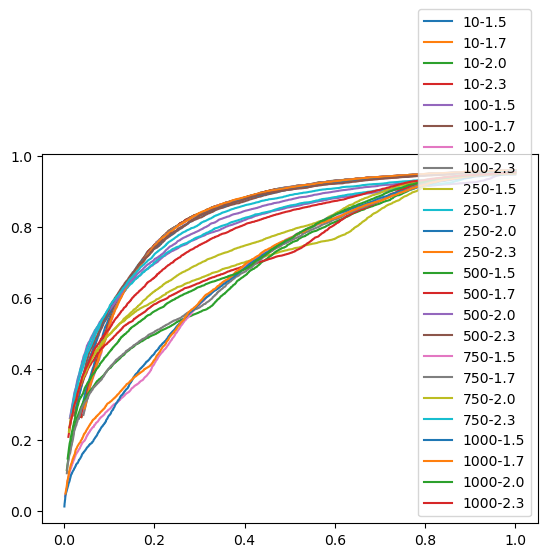

In [60]:
fig, axs = plt.subplots(1, 1)
for key in ccr_fpr_dict.keys():
    axs.plot(ccr_fpr_dict[key][1] , ccr_fpr_dict[key][0], label=key)
plt.legend(loc='lower right')
plt.show()